# Preprocess

In [2]:
# Environmental Preparation

import pandas as pd
import numpy as np
from pathlib import Path

pd.set_option("display.max_columns", None)

DATA_PATH = Path("../data/fraud_detection_data.csv")

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()

print(f"data shape: {df.shape}")
df.head()


data shape: (1852394, 22)


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
# Data Types and Preliminary Cleanup
# 1. Convert timestamps
df["transacted_at"] = pd.to_datetime(df["trans_date_trans_time"], errors="coerce")

# 2. Handle numeric types (ignore unconvertible values)
numeric_cols = ["amt", "zip", "lat", "long", "city_pop", "merch_lat", "merch_long", "unix_time"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 3. Remove duplicate records (if trans_num is repeated, keep the first one)
duplicates = df.duplicated(subset="trans_num", keep="first")
if duplicates.any():
    print(f"Have removed {duplicates.sum()} duplicated records")
    df = df[~duplicates]

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  object        
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    object        
 17  trans_num              object        
 18  unix_time             

In [4]:
# Cell 3 ── Missing value check
missing_summary = (
    df.isna()
      .sum()
      .pipe(lambda s: s[s > 0])
      .sort_values(ascending=False)
      .to_frame("missing_count")
)

missing_summary["missing_rate"] = missing_summary["missing_count"] / len(df)
missing_summary


,missing_count,missing_rate


In [5]:
# Cell 5 Outlier handling
def winsorize_series(series: pd.Series, k: float = 1.5) -> pd.Series:
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return series.clip(lower, upper)


outlier_cols = ["amt", "city_pop", "lat", "long", "merch_lat", "merch_long"]
df[outlier_cols] = df[outlier_cols].apply(winsorize_series)


if (df["amt"] < 0).any():
    print("converted negatived value to positive")
    df["amt"] = df["amt"].abs()


In [6]:
# Cell 6 Standardization and consistency check of categorical variables
# Gender is unified into lowercase and outliers are replaced
df["gender"] = (
    df["gender"]
      .str.strip()
      .str.upper()
      .replace({"FEMALE": "F", "MALE": "M"})
)

# Transaction categories are all lowercase
df["category"] = df["category"].str.strip().str.lower()

# State names are converted to uppercase. State names other than two letters can be set to "UNK"
df["state"] = (
    df["state"]
      .str.strip()
      .str.upper()
      .where(lambda s: s.str.len() == 2, other="UNK")
)

# Check and address extremely rare business tags (e.g., if they appear less than 5 times, they are classified as 'other')
merchant_counts = df["merchant"].value_counts()
rare_merchants = merchant_counts[merchant_counts < 5].index
df["merchant"] = df["merchant"].where(~df["merchant"].isin(rare_merchants), other="other")


In [7]:
# Cell 7 Check the results after missing and abnormal processing
post_missing = df.isna().sum()
post_missing[post_missing > 0]


Series([], dtype: int64)

In [17]:
# Cell 8 ── Data integrity and basic statistical review
# summary_table = df.describe().transpose()
numeric_cols = df.select_dtypes(include="number")
numeric_summary_explicit = numeric_cols.describe().applymap(lambda x: f"{x:.1f}")
numeric_summary_explicit

C:\Users\guoxi\AppData\Local\Temp\ipykernel_42816\135651125.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_summary_explicit = numeric_cols.describe().applymap(lambda x: f"{x:.1f}")


,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1852394.0,1852394.0,1852394.0,1852394.0,1852394.0,1852394.0,1852394.0,1852394.0,1852394.0,1852394.0
mean,417386038393710400.0,57.8,48813.3,38.5,-90.1,13543.2,1358674218.8,38.5,-90.1,0.0
std,1309115265318020352.0,53.0,26881.8,5.0,13.2,19152.8,18195081.4,5.0,13.2,0.1
min,60416207185.0,1.0,1257.0,23.8,-121.8,23.0,1325376018.0,23.9,-121.9,0.0
25%,180042946491150.0,9.6,26237.0,34.7,-96.8,741.0,1343016823.8,34.7,-96.9,0.0
50%,3521417320836166.0,47.5,48174.0,39.4,-87.5,2443.0,1357089331.0,39.4,-87.4,0.0
75%,4642255475285942.0,83.1,72042.0,41.9,-80.2,20328.0,1374581485.2,42.0,-80.2,0.0
max,4992346398065154048.0,193.3,99921.0,52.8,-68.0,49708.5,1388534374.0,52.8,-67.0,1.0


In [20]:
df.describe(include=["object"]).transpose()

,count,unique,top,freq
trans_date_trans_time,1852394,1819551,2019-04-22 16:02:01,4
merchant,1852394,693,fraud_Kilback LLC,6262
category,1852394,14,gas_transport,188029
first,1852394,355,Christopher,38112
last,1852394,486,Smith,40940
gender,1852394,2,F,1014749
street,1852394,999,908 Brooks Brook,4392
city,1852394,906,Birmingham,8040
state,1852394,51,TX,135269
job,1852394,497,Film/video editor,13898


# Visualization

In [10]:
# Cell 1 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

clean_df = df
clean_df["is_fraud"] = clean_df["is_fraud"].astype(int)
clean_df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,transacted_at
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01 00:00:18
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01 00:00:44
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,193.29,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01 00:00:51
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01 00:01:16
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01 00:03:06



### 1. Distribution of txn amount of fraud and non-fraud

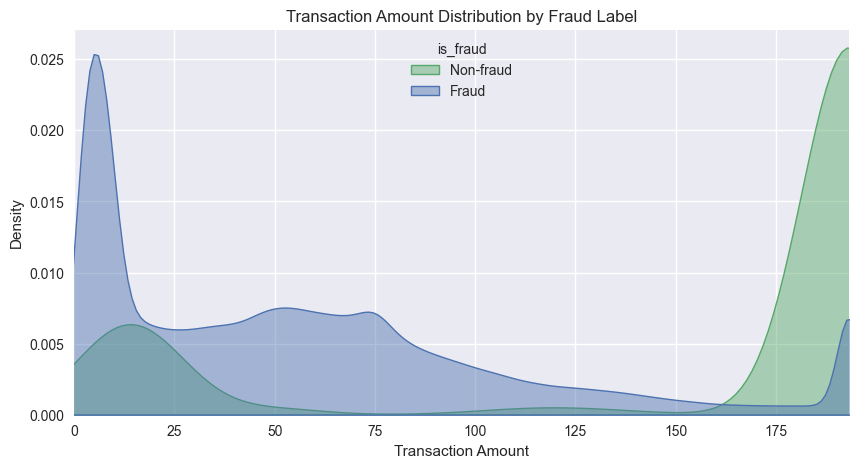

In [11]:

plt.figure(figsize=(10, 5))
sns.kdeplot(
    data=clean_df,
    x="amt",
    hue="is_fraud",
    fill=True,
    common_norm=False,
    alpha=0.45,
    linewidth=1,
)
plt.title("Transaction Amount Distribution by Fraud Label")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend(title="is_fraud", labels=["Non-fraud", "Fraud"])
plt.xlim(0, clean_df["amt"].quantile(0.99))  
plt.show()


### 2. Fraud rates by transaction category

C:\Users\guoxi\AppData\Local\Temp\ipykernel_23316\2535717424.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


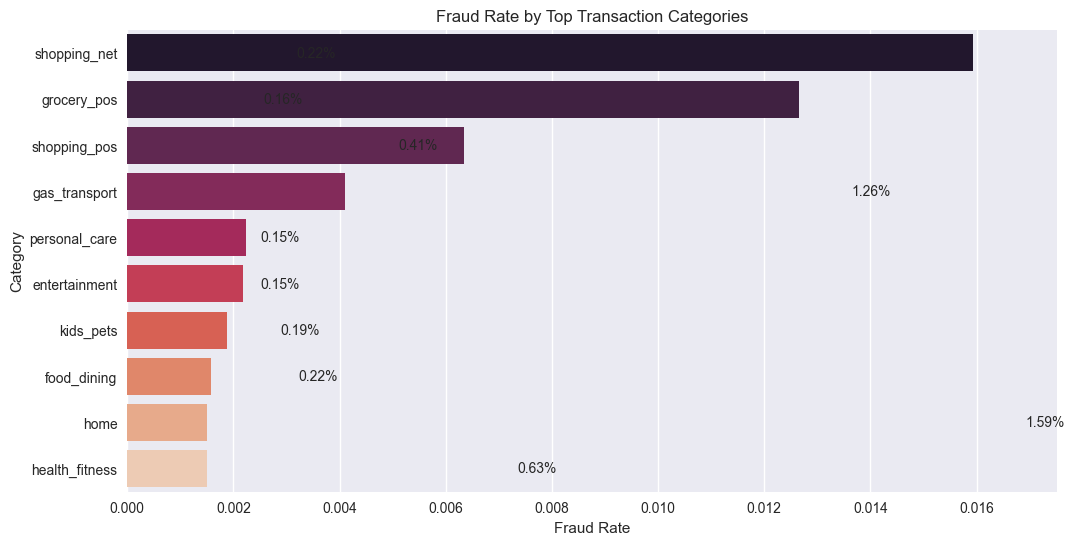

In [12]:
# Cell 3 
top_categories = (
    clean_df["category"]
    .value_counts()
    .head(10)
    .index
)

category_summary = (
    clean_df[clean_df["category"].isin(top_categories)]
    .groupby("category")
    .agg(
        transactions=("is_fraud", "size"),
        fraud_cases=("is_fraud", "sum")
    )
    .assign(fraud_rate=lambda df: df["fraud_cases"] / df["transactions"])
    .reset_index()
    .sort_values("fraud_rate", ascending=False)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=category_summary,
    x="fraud_rate",
    y="category",
    palette="rocket"
)
plt.title("Fraud Rate by Top Transaction Categories")
plt.xlabel("Fraud Rate")
plt.ylabel("Category")
plt.xlim(0, category_summary["fraud_rate"].max() * 1.1)
for index, row in category_summary.iterrows():
    plt.text(row["fraud_rate"] + 0.001, index, f"{row['fraud_rate']:.2%}", va="center")
plt.show()


### 3. Distance anomaly between transaction location and merchant location (simple approximation)

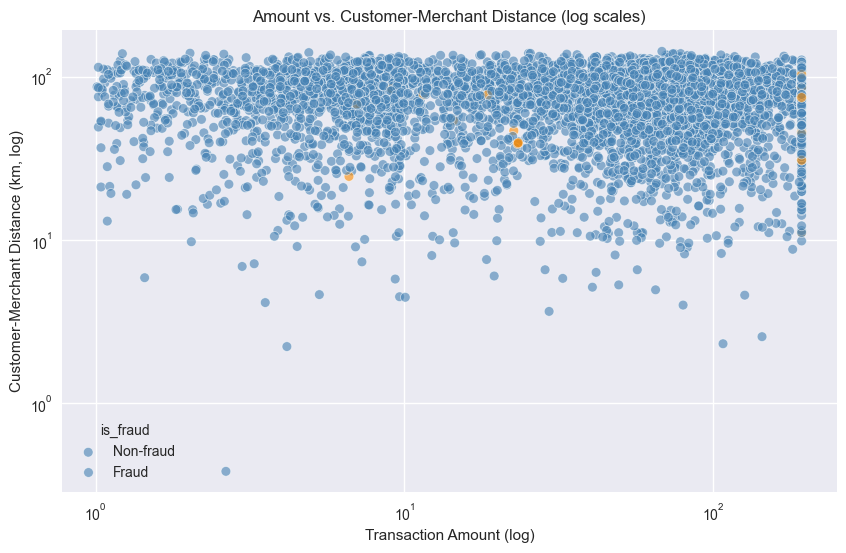

In [13]:
# Cell 4 Scattered distances between transaction locations and merchant locations (rough approximation)
# Approximate latitude and longitude distances, for visual reference only
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    d_lat = lat2 - lat1
    d_lon = lon2 - lon1
    a = np.sin(d_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_lon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

sample = clean_df.dropna(subset=["lat", "long", "merch_lat", "merch_long"]).sample(5000, random_state=42)

sample["customer_merchant_distance_km"] = haversine(
    sample["long"],
    sample["lat"],
    sample["merch_long"],
    sample["merch_lat"],
)


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sample,
    x="amt",
    y="customer_merchant_distance_km",
    hue="is_fraud",
    alpha=0.6,
    palette={0: "steelblue", 1: "darkorange"},
)
plt.yscale("log")
plt.xscale("log")
plt.title("Amount vs. Customer-Merchant Distance (log scales)")
plt.xlabel("Transaction Amount (log)")
plt.ylabel("Customer-Merchant Distance (km, log)")
plt.legend(title="is_fraud", labels=["Non-fraud", "Fraud"])
plt.show()
